In [33]:
from datetime import datetime, timedelta
import math
import numpy as np  # linear algebra_
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

--################################
--################################
--данный SQL код подготавливает датасет aero.csv для Юпитернотбука
SELECT count(s.seat_no) count_seats,a.aircraft_code
FROM dst_project.seats s 
join dst_project.aircrafts a on s.aircraft_code=a.aircraft_code
group by a.aircraft_code
),
mainds as (
SELECT *,f.scheduled_arrival-f.scheduled_departure dt
FROM dst_project.flights f
WHERE departure_airport = 'AAQ'
  AND (date_trunc('month', scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
  AND status not in ('Cancelled')
--limit 20
)
select mainds.flight_id, mainds.flight_no,
sum(coalesce(tf.amount,0))/(date_part('hour',mainds.dt)*60+date_part('minute',mainds.dt)) flight_minute_profit,
sum(coalesce(tf.amount,0)) money_collected,
mainds.arrival_airport, 
EXTRACT(DOW FROM mainds.scheduled_departure),
mainds.scheduled_departure,
count(tf.ticket_no)*100/aircraft_seats_count.count_seats occupancy,
date_part('hour',mainds.dt)*60+date_part('minute',mainds.dt) flight_duaration, 
count(tf.ticket_no) count_seats_sold,
aircraft_seats_count.count_seats count_seats_total
from mainds
left join dst_project.ticket_flights tf on tf.flight_id=mainds.flight_id
left join aircraft_seats_count on aircraft_seats_count.aircraft_code=mainds.aircraft_code
group by mainds.flight_id, mainds.flight_no,mainds.scheduled_departure,mainds.dt,
mainds.arrival_airport,aircraft_seats_count.count_seats
order by 3 desc
--################################
--################################


In [77]:
dff = pd.read_csv('aero.csv')
dff['scheduled_departure'].sort_values()
# хоть мы рассматриваем зиму, за декабрь 2017 года данных в базе нет. остается только январь и февраль 2017

71     2017-01-01T09:25:00Z
44     2017-01-01T10:05:00Z
107    2017-01-02T09:25:00Z
37     2017-01-02T10:05:00Z
121    2017-01-03T06:10:00Z
               ...         
56     2017-02-27T09:25:00Z
40     2017-02-27T10:05:00Z
120    2017-02-28T06:10:00Z
115    2017-02-28T09:25:00Z
26     2017-02-28T10:05:00Z
Name: scheduled_departure, Length: 127, dtype: object

In [35]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             127 non-null    int64  
 1   flight_no             127 non-null    object 
 2   flight_minute_profit  127 non-null    float64
 3   money_collected       127 non-null    float64
 4   arrival_airport       127 non-null    object 
 5   date_part             127 non-null    float64
 6   scheduled_departure   127 non-null    object 
 7   occupancy             127 non-null    int64  
 8   flight_duaration      127 non-null    float64
 9   count_seats_sold      127 non-null    int64  
 10  count_seats_total     127 non-null    int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 11.0+ KB


In [92]:
dff.sample(5)
# при подготовке датасета с помощью sql запроса добавленны новые поля:

# flight_minute_profit=money_collected/flight_duaration - условная единица удельной прибыльности одной минуты полета, равная выручек от рейса делить на длительность рейса
# money_collected - сумма за полет (суммирование стоимости проданных билетов за рейс)
# date_part - день недели
# occupancy =count_seats_sold/count_seats_total- заполняемость самолета в рейсе (количество проданных мест делить на количество мест в данном самолете)
# flight_duaration - длительность рейса в минутах
# count_seats_sold - количество проданных мест  на рейс
# count_seats_total -количество мест в данном самолете

,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
87,136360,PG0252,14554.0,1455400.0,SVO,0.0,2017-02-05T10:05:00Z,74,100.0,97,130
99,136709,PG0480,13794.0,689700.0,EGO,0.0,2017-01-15T09:25:00Z,89,50.0,87,97
8,136436,PG0252,18116.0,1811600.0,SVO,4.0,2017-01-26T10:05:00Z,95,100.0,124,130
56,136953,PG0480,15306.0,765300.0,EGO,1.0,2017-02-27T09:25:00Z,100,50.0,97,97
75,136720,PG0480,15054.0,752700.0,EGO,4.0,2017-01-26T09:25:00Z,97,50.0,95,97


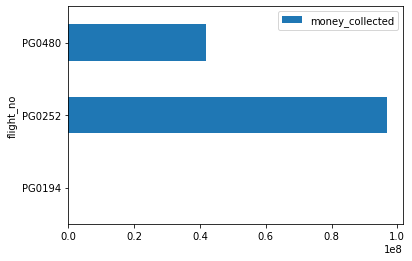

In [39]:
fl = dff.groupby(['flight_no'])[['money_collected']].sum().plot(kind='barh')
# сопоставление общей прибыли от полетов трех рейсов, вылетающих из Анапы

In [38]:
# или выбросы, или абсолютно невыгодный рейс без пассажиров
dff[dff.flight_no == 'PG0194']

,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
118,136560,PG0194,0.0,0.0,NOZ,2.0,2017-01-24T06:10:00Z,0,305.0,0,130
119,136567,PG0194,0.0,0.0,NOZ,2.0,2017-02-14T06:10:00Z,0,305.0,0,130
120,136513,PG0194,0.0,0.0,NOZ,2.0,2017-02-28T06:10:00Z,0,305.0,0,130
121,136546,PG0194,0.0,0.0,NOZ,2.0,2017-01-03T06:10:00Z,0,305.0,0,130
122,136514,PG0194,0.0,0.0,NOZ,2.0,2017-02-07T06:10:00Z,0,305.0,0,130
123,136544,PG0194,0.0,0.0,NOZ,2.0,2017-01-31T06:10:00Z,0,305.0,0,130
124,136523,PG0194,0.0,0.0,NOZ,2.0,2017-01-10T06:10:00Z,0,305.0,0,130
125,136540,PG0194,0.0,0.0,NOZ,2.0,2017-01-17T06:10:00Z,0,305.0,0,130
126,136511,PG0194,0.0,0.0,NOZ,2.0,2017-02-21T06:10:00Z,0,305.0,0,130


In [7]:
df = dff[dff.flight_no != 'PG0194']  # удалить данные по рейсу PG0194
df

,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
0,136226,PG0252,18860.0,1886000.0,SVO,1.0,2017-01-30T10:05:00Z,100,100.0,130,130
1,136316,PG0252,18860.0,1886000.0,SVO,4.0,2017-01-12T10:05:00Z,100,100.0,130,130
2,136403,PG0252,18738.0,1873800.0,SVO,1.0,2017-02-20T10:05:00Z,99,100.0,129,130
3,136389,PG0252,18738.0,1873800.0,SVO,3.0,2017-01-18T10:05:00Z,99,100.0,129,130
4,136423,PG0252,18494.0,1849400.0,SVO,2.0,2017-01-10T10:05:00Z,99,100.0,129,130
...,...,...,...,...,...,...,...,...,...,...,...
113,136922,PG0480,12156.0,607800.0,EGO,6.0,2017-02-11T09:25:00Z,78,50.0,76,97
114,136887,PG0480,11904.0,595200.0,EGO,5.0,2017-01-20T09:25:00Z,80,50.0,78,97
115,136844,PG0480,11502.0,575100.0,EGO,2.0,2017-02-28T09:25:00Z,81,50.0,79,97
116,136642,PG0480,10620.0,531000.0,EGO,1.0,2017-01-30T09:25:00Z,65,50.0,64,97


In [9]:
fl = df['flight_no'].value_counts()
display(fl)

PG0480    59
PG0252    59
Name: flight_no, dtype: int64

<AxesSubplot:>

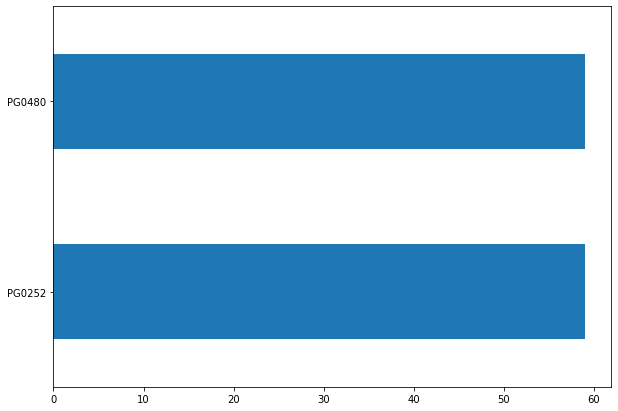

In [20]:
df['flight_no'].value_counts(ascending=True).plot(kind='barh')
#количество вылетов одинаковое

In [31]:
# анализ прибыльности минуты полета раздельно для двух рейсов (третий рейс PG0194 выбросили из рассмотрения - пассажиров нет или ошибка в базе)
fl = df[df.flight_no == 'PG0252']['flight_minute_profit'].value_counts(bins=10)
display(fl)

(16420.0, 16908.0]      10
(14956.0, 15444.0]       8
(15932.0, 16420.0]       7
(15444.0, 15932.0]       7
(18372.0, 18860.0]       5
(17884.0, 18372.0]       5
(16908.0, 17396.0]       5
(17396.0, 17884.0]       4
(14468.0, 14956.0]       4
(13975.119, 14468.0]     4
Name: flight_minute_profit, dtype: int64

<AxesSubplot:>

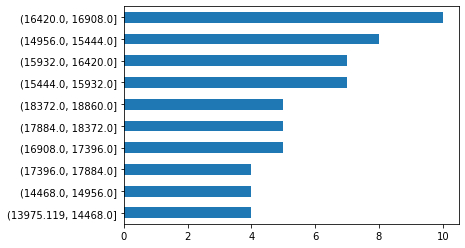

In [29]:
df[df.flight_no=='PG0252']['flight_minute_profit'].value_counts(bins=10,ascending=True).plot(kind='barh')

In [95]:
fl=df[df.flight_no=='PG0480']['flight_minute_profit'].value_counts(bins=10).sort_values()
display(fl)

(11557.2, 12025.8]       1
(11088.6, 11557.2]       1
(10615.313, 11088.6]     2
(14368.8, 14837.4]       3
(13431.6, 13900.2]       3
(12963.0, 13431.6]       3
(12025.8, 12494.4]       3
(13900.2, 14368.8]       5
(12494.4, 12963.0]       6
(14837.4, 15306.0]      32
Name: flight_minute_profit, dtype: int64

<AxesSubplot:>

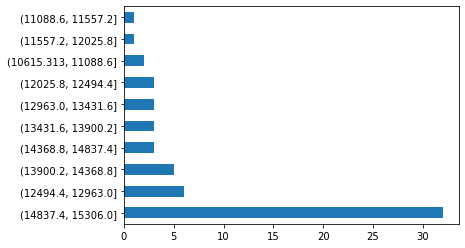

In [30]:
df[df.flight_no=='PG0480']['flight_minute_profit'].value_counts(bins=10).plot(kind='barh')

In [43]:
fl.index[0].left

14837.4

In [97]:
sample=df.loc[(df.flight_no=='PG0480') & (df.flight_minute_profit<11089)]
display(sample)


,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
116,136642,PG0480,10620.0,531000.0,EGO,1.0,2017-01-30T09:25:00Z,65,50.0,64,97
117,136807,PG0480,10620.0,531000.0,EGO,4.0,2017-02-23T09:25:00Z,70,50.0,68,97


<AxesSubplot:xlabel='scheduled_departure'>

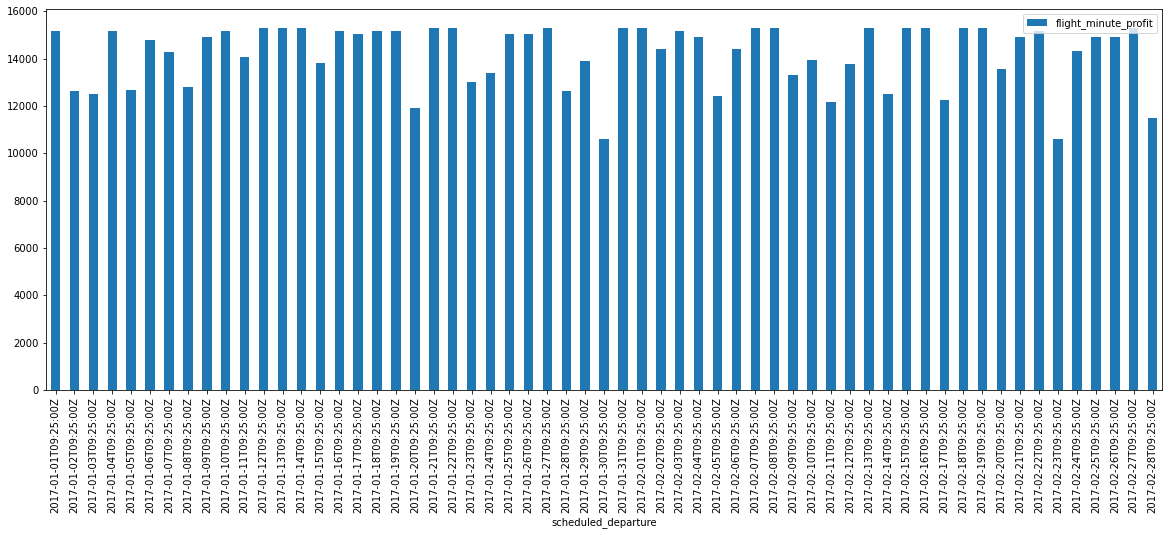

In [82]:
plt.rcParams['figure.figsize'] = (20,7)
df[df.flight_no=='PG0480'].groupby('scheduled_departure')[['flight_minute_profit']].mean().plot(kind = 'bar')


<AxesSubplot:xlabel='date_part'>

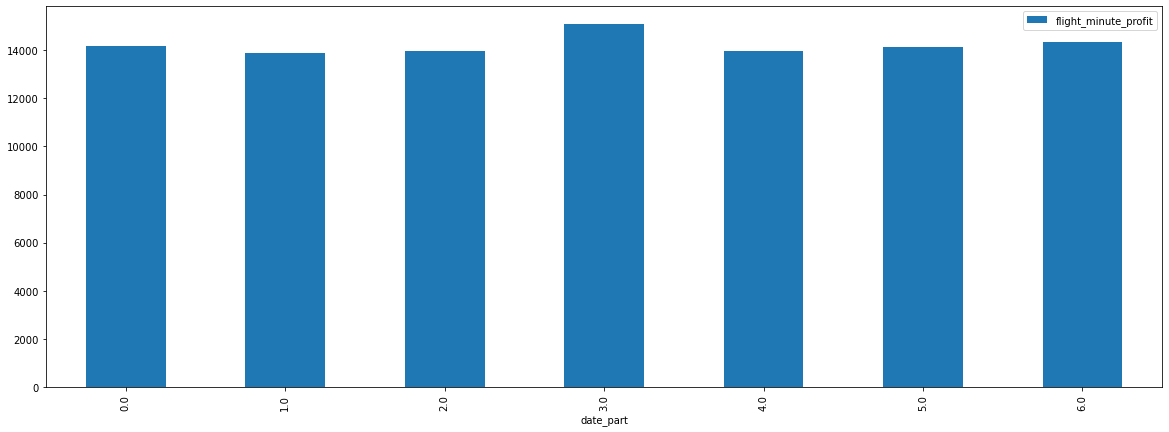

In [83]:
df[df.flight_no=='PG0480'].groupby('date_part')[['flight_minute_profit']].mean().plot(kind = 'bar')

In [98]:
sample=df.loc[(df.flight_no=='PG0480') & (df.occupancy<=81)].sort_values(by='scheduled_departure')
display(sample)


,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
114,136887,PG0480,11904.0,595200.0,EGO,5.0,2017-01-20T09:25:00Z,80,50.0,78,97
116,136642,PG0480,10620.0,531000.0,EGO,1.0,2017-01-30T09:25:00Z,65,50.0,64,97
111,136823,PG0480,12408.0,620400.0,EGO,0.0,2017-02-05T09:25:00Z,80,50.0,78,97
113,136922,PG0480,12156.0,607800.0,EGO,6.0,2017-02-11T09:25:00Z,78,50.0,76,97
109,136888,PG0480,12522.0,626100.0,EGO,2.0,2017-02-14T09:25:00Z,81,50.0,79,97
112,136620,PG0480,12270.0,613500.0,EGO,5.0,2017-02-17T09:25:00Z,81,50.0,79,97
117,136807,PG0480,10620.0,531000.0,EGO,4.0,2017-02-23T09:25:00Z,70,50.0,68,97
115,136844,PG0480,11502.0,575100.0,EGO,2.0,2017-02-28T09:25:00Z,81,50.0,79,97


In [19]:
df[df.flight_minute_profit<12000]

,flight_id,flight_no,flight_minute_profit,money_collected,arrival_airport,date_part,scheduled_departure,occupancy,flight_duaration,count_seats_sold,count_seats_total
114,136887,PG0480,11904.0,595200.0,EGO,5.0,2017-01-20T09:25:00Z,80,50.0,78,97
115,136844,PG0480,11502.0,575100.0,EGO,2.0,2017-02-28T09:25:00Z,81,50.0,79,97
116,136642,PG0480,10620.0,531000.0,EGO,1.0,2017-01-30T09:25:00Z,65,50.0,64,97
117,136807,PG0480,10620.0,531000.0,EGO,4.0,2017-02-23T09:25:00Z,70,50.0,68,97


<AxesSubplot:xlabel='scheduled_departure'>

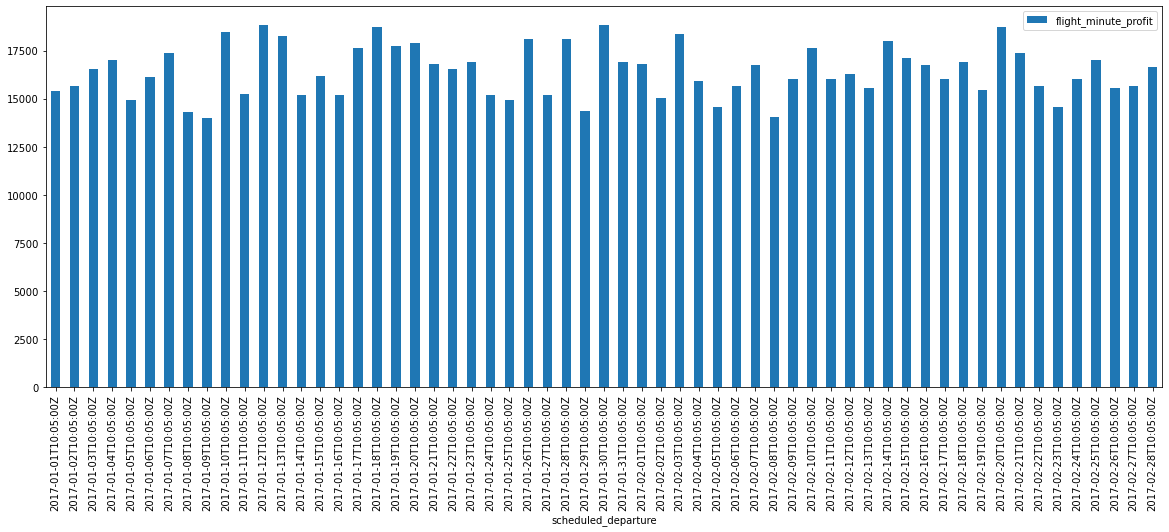

In [84]:
df[df.flight_no=='PG0252'].groupby('scheduled_departure')[['flight_minute_profit']].mean().plot(kind = 'bar')


<AxesSubplot:xlabel='date_part'>

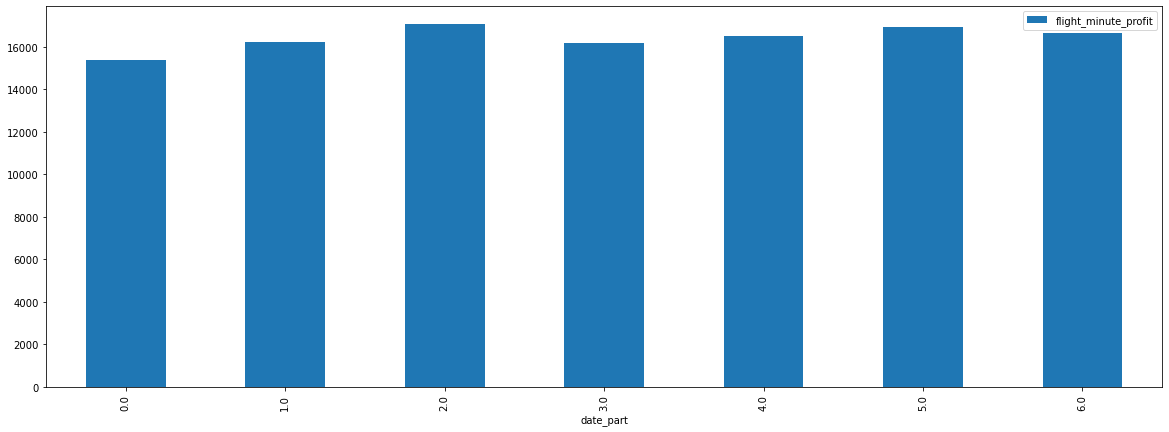

In [85]:
df[df.flight_no=='PG0252'].groupby('date_part')[['flight_minute_profit']].mean().plot(kind = 'bar')

array([<AxesSubplot:title={'center':'flight_minute_profit'}, xlabel='date_part,flight_no'>],
      dtype=object)

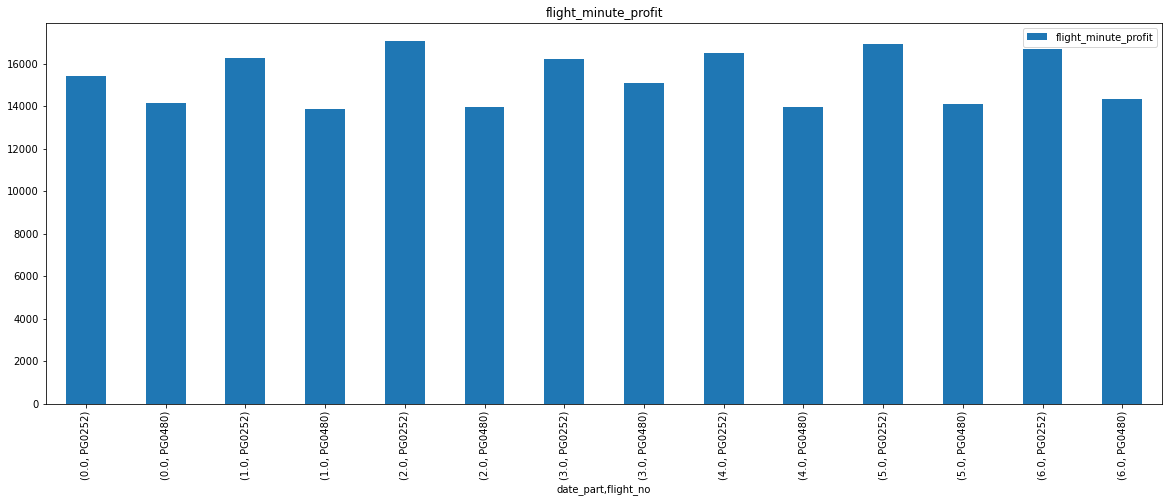

In [89]:
df.groupby(['date_part','flight_no'])[['flight_minute_profit']].mean().plot(subplots = True, kind = 'bar')

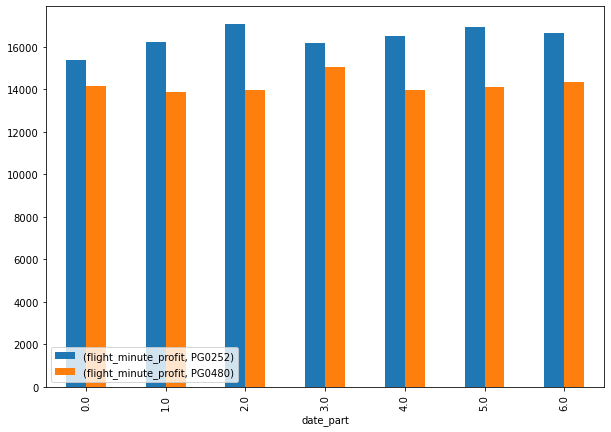

In [135]:
axes=df.pivot_table(values = ['flight_minute_profit'], 
               index = 'date_part', 
               columns=['flight_no'],
               aggfunc = 'mean').plot(kind = 'bar')
axes.legend(loc = 3)

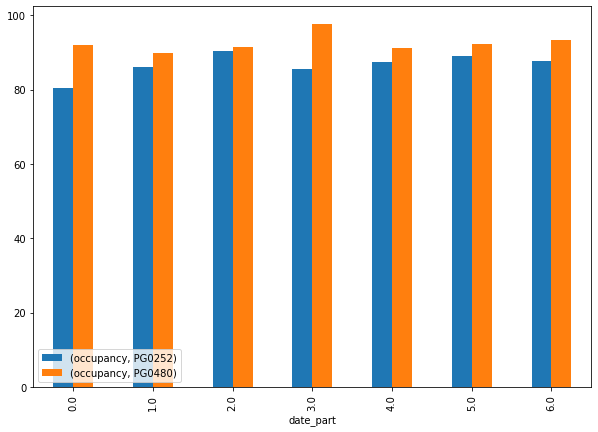

In [136]:
axes=df.pivot_table(values = ['occupancy'], 
               index = 'date_part', 
               columns=['flight_no'],
               aggfunc = 'mean').plot(kind = 'bar')
axes.legend(loc = 3)

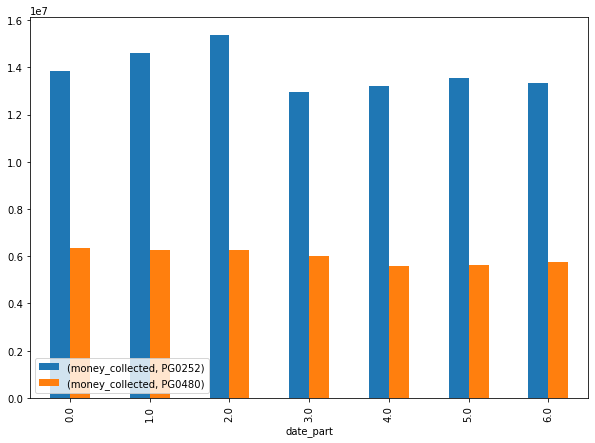

In [137]:
axes=df.pivot_table(values = ['money_collected'], 
               index = 'date_part', 
               columns=['flight_no'],
               aggfunc = 'sum').plot(kind = 'bar')
axes.legend(loc = 3)

In [23]:
fl=df.groupby(['flight_no', 'date_part'])[[ 'flight_minute_profit', 'money_collected',
        'occupancy', 'flight_duaration', 'count_seats_sold', 'count_seats_total']].mean()
display(fl)

flight_minute_profit  money_collected  occupancy  \
flight_no date_part                                                     
PG0252    0.0                15403.555556     1.540356e+06  80.444444   
          1.0                16250.666667     1.625067e+06  86.111111   
          2.0                17058.666667     1.705867e+06  90.444444   
          3.0                16203.750000     1.620375e+06  85.500000   
          4.0                16514.750000     1.651475e+06  87.375000   
          5.0                16946.250000     1.694625e+06  89.000000   
          6.0                16673.250000     1.667325e+06  87.625000   
PG0480    0.0                14155.333333     7.077667e+05  91.888889   
          1.0                13886.666667     6.943333e+05  89.888889   
          2.0                13969.333333     6.984667e+05  91.555556   
          3.0                15069.750000     7.534875e+05  97.500000   
          4.0                13978.500000     6.989250e+05  91.250000   
          5.0                14123.250000     7.061625e+05  92.125000   
          6.0                14355.000000     7.177500e+05  93.375000   

                     flight_duaration  count_seats_sold  count_seats_total  
flight_no date_part                                                         
PG0252    0.0                   100.0        105.111111              130.0  
          1.0                   100.0        112.444444              130.0  
          2.0                   100.0        118.222222              130.0  
          3.0                   100.0        111.625000              130.0  
          4.0                   100.0        114.125000              130.0  
          5.0                   100.0        116.375000              130.0  
          6.0                   100.0        114.375000              130.0  
PG0480    0.0                    50.0         89.666667               97.0  
          1.0                    50.0         87.777778               97.0  
          2.0                    50.0         89.333333               97.0  
          3.0                    50.0         95.125000               97.0  
          4.0                    50.0         89.000000               97.0  
          5.0                    50.0         89.875000               97.0  
          6.0                    50.0         91.000000               97.0

In [ ]:
#анализ прибыльности/убыточности каких-то особых дат или дней недели ничего особенного не дает.
#для рейса PG0480 являются менее прибыльными последние числа месяца(январь, февраль) (для декабря данных нет)
#а для рейса PG0252 по воскресеньям наблюдается наиболее низкая заполняемость самолета (80%).
#возможно, если отменить воскресные рейсы PG0252, это повысит заполняемость других дней недели и в целом окажется выгодным.

In [27]:
fl=df.groupby(['flight_no', 'date_part'])[[ 'money_collected',
        'flight_duaration', 'count_seats_sold', 'count_seats_total']].sum()
display(fl)

money_collected  flight_duaration  count_seats_sold  \
flight_no date_part                                                        
PG0252    0.0             13863200.0             900.0               946   
          1.0             14625600.0             900.0              1012   
          2.0             15352800.0             900.0              1064   
          3.0             12963000.0             800.0               893   
          4.0             13211800.0             800.0               913   
          5.0             13557000.0             800.0               931   
          6.0             13338600.0             800.0               915   
PG0480    0.0              6369900.0             450.0               807   
          1.0              6249000.0             450.0               790   
          2.0              6286200.0             450.0               804   
          3.0              6027900.0             400.0               761   
          4.0              5591400.0             400.0               712   
          5.0              5649300.0             400.0               719   
          6.0              5742000.0             400.0               728   

                     count_seats_total  
flight_no date_part                     
PG0252    0.0                     1170  
          1.0                     1170  
          2.0                     1170  
          3.0                     1040  
          4.0                     1040  
          5.0                     1040  
          6.0                     1040  
PG0480    0.0                      873  
          1.0                      873  
          2.0                      873  
          3.0                      776  
          4.0                      776  
          5.0                      776  
          6.0                      776

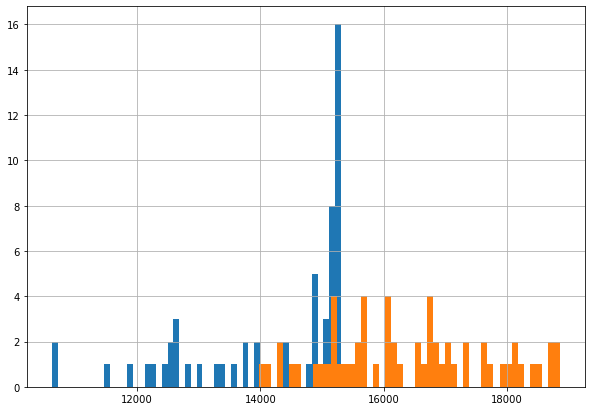

In [94]:
plt.rcParams['figure.figsize'] = (10,7)
for x in (df['flight_no'].value_counts()).index:
    df['flight_minute_profit'][df['flight_no'] == x].hist(bins=50)
plt.show()

<AxesSubplot:>

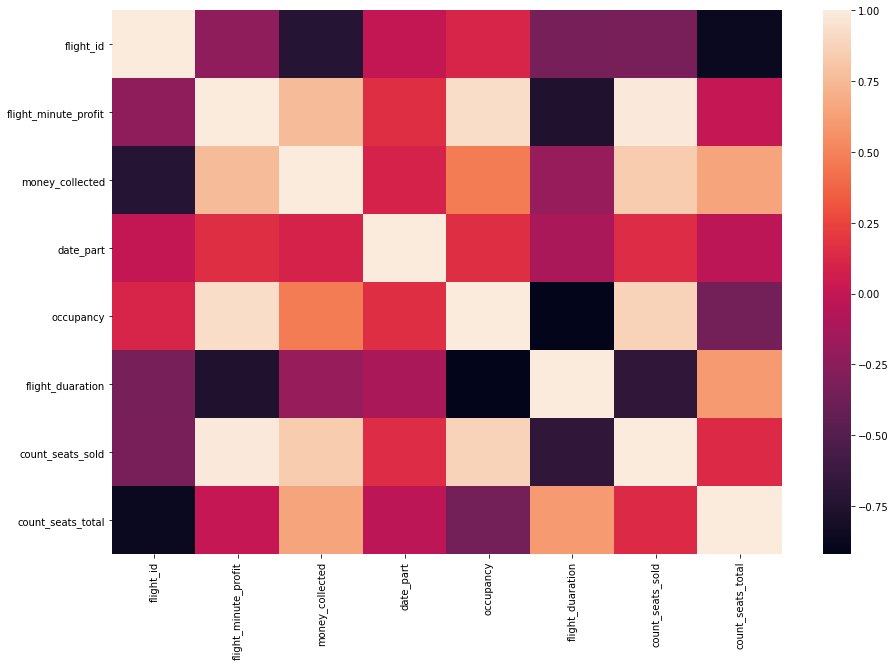

In [11]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(),)

In [12]:
df.columns

Index(['flight_id', 'flight_no', 'flight_minute_profit', 'money_collected',
       'arrival_airport', 'date_part', 'scheduled_departure', 'occupancy',
       'flight_duaration', 'count_seats_sold', 'count_seats_total'],
      dtype='object')

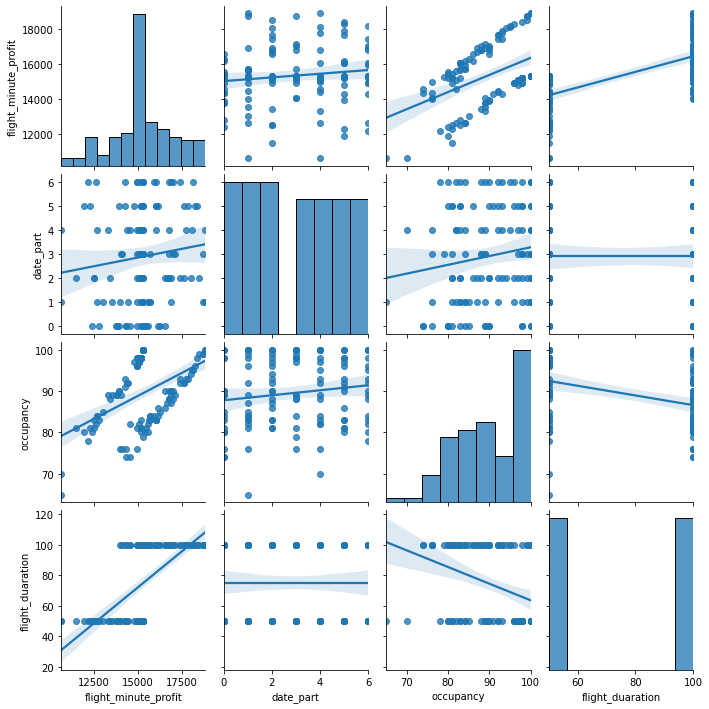

In [26]:
cols=['flight_no', 'flight_minute_profit',
       'date_part', 'occupancy',
       'flight_duaration']
sns.pairplot(df[cols], kind='reg');